In [6]:
import json
import piexif
from PIL import Image
import os
import pickle
from shutil import copyfile, unpack_archive, move
import pandas as pd
from scrapper import scrapper

In [7]:
with open("meta.json", encoding="UTF-8") as fl:
    meta=json.load(fl)
meta

{'github': {'commit': '659e7e0df1ac7d7e876d07c33341f2e625cba3d4',
  'repo': 'borutb-fri/FMLD'},
 'annotations': {'id': 'FMLD_annotations.zip', 'src': 'github'},
 'train': [{'img': {'id': '15hGDLhsx8bLgLcIRD5DhYt5iBxnjNF1M',
    'out': 'wide-train.zip',
    'src': 'drive'}},
  {'img': {'id': '17bRIiaGyrKLEDQOV2RlqbPQ9TyCZxq9k',
    'out': 'mafa-train.zip',
    'src': 'drive'}}],
 'test': [{'img': {'id': '1GUCogbp16PMGa39thoMMeWxp7Rp5oM8Q',
    'out': 'wide-test.zip',
    'src': 'drive'}},
  {'img': {'id': '1jJHdmmscqxvNQ2dxKUrLaHqW3w1Yo_9S',
    'out': 'mafa-test.zip',
    'src': 'drive'}}]}

In [8]:
github_info = meta["github"]

In [9]:
scrapper(meta["annotations"], github_info)
[scrapper(el['img'], github_info) for el in meta["train"]]
[scrapper(el['img'], github_info) for el in meta["test"]] 

Downloading...
From: https://drive.google.com/uc?id=15hGDLhsx8bLgLcIRD5DhYt5iBxnjNF1M
To: /home/reybroncas/github/muzzle-detector/wide-train.zip
100%|█████████████████████████████████████████████████████| 1.47G/1.47G [03:15<00:00, 7.49MB/s]
Downloading...
From: https://drive.google.com/uc?id=17bRIiaGyrKLEDQOV2RlqbPQ9TyCZxq9k
To: /home/reybroncas/github/muzzle-detector/mafa-train.zip
100%|█████████████████████████████████████████████████████| 1.96G/1.96G [04:27<00:00, 7.31MB/s]
Downloading...
From: https://drive.google.com/uc?id=1GUCogbp16PMGa39thoMMeWxp7Rp5oM8Q
To: /home/reybroncas/github/muzzle-detector/wide-test.zip
100%|███████████████████████████████████████████████████████| 363M/363M [00:50<00:00, 7.23MB/s]
Downloading...
From: https://drive.google.com/uc?id=1jJHdmmscqxvNQ2dxKUrLaHqW3w1Yo_9S
To: /home/reybroncas/github/muzzle-detector/mafa-test.zip
100%|███████████████████████████████████████████████████████| 466M/466M [01:02<00:00, 7.41MB/s]


[None, None]

In [10]:
unpack_archive("FMLD_annotations.zip", ".")
unpack_archive("wide-test.zip", ".")
unpack_archive("wide-train.zip", ".")
unpack_archive("mafa-test.zip", ".")
move("images", "test-images")
unpack_archive("mafa-train.zip", ".")
move("images", "train-images")

'train-images'

In [13]:
import cv2
import xml.etree.ElementTree as ET

class Annotation:
    THRESHOLD = 50
    
    def __init__(self, root):
        if not os.path.isdir(root):
            raise Exception("FUCK")
        self.iter = (f"{subs}/{fl}" for subs, dirs, fls in os.walk(root) for fl in fls)
    
    def save_faces(self):
        to_int = lambda val: int(float(val))
        get_object = lambda obj, w, h, d: {
                "name": obj.find("name").text,
                "gender": obj.find("gender").text,
                "ethnisity": obj.find("ethnicity").text,
                "pose": obj.find("pose").text,
                "truncated": obj.find("truncated").text,
                "difficult": obj.find("difficult").text,
                "x0": max(0, to_int(obj.find("bndbox").find("xmin").text)),
                "y0": max(0, to_int(obj.find("bndbox").find("ymin").text)),
                "x1": min(w, to_int(obj.find("bndbox").find("xmax").text)),
                "y1": min(h, to_int(obj.find("bndbox").find("ymax").text)),
        }
        
        for fl in self.iter:
            try:
                name, _ = fl.split(".xml")
                *_, name = name.split(os.sep)
            except:
                print(name)
                continue
            
            root = ET.parse(fl)
            path = root.find("path").text
            folder = root.find("folder").text
            if not os.path.isdir(folder):
                os.mkdir(folder)
            source = root.find("source").find("database").text
            size = root.find("size")
            dim = {
                "w": to_int(size.find("width").text), 
                "h": to_int(size.find("height").text), 
                "d": to_int(size.find("depth").text)
            }
            segmented = root.find("segmented").text
            faces = self.__get_faces(map(lambda obj: get_object(obj, **dim), root.findall("object")), path)
            for ind, (face, exif) in enumerate(faces):
                face_path = f"{folder}{os.sep}{name}_{ind}.jpg"
                face.save(face_path, exif=exif)
    
    def read_faces(self):
        for fl in self.iter:   
            meta = self.face_meta(fl)
            yield meta
            
    
    @staticmethod
    def __face_exif(path, obj_dict): 
        return piexif.dump({"Exif": {piexif.ExifIFD.MakerNote: pickle.dumps({
            "path": path,
            **obj_dict
        })}})
    
    @staticmethod
    def face_meta(path):
        exif_dict = piexif.load(path)
        return pickle.loads(exif_dict["Exif"][piexif.ExifIFD.MakerNote])
    
    @staticmethod
    def __get_faces(objs, fl):
        img = cv2.imread(fl)
        if img is None:
            raise Exception(f"No image: {fl}")
        for obj in objs:
            y0,y1,x0,x1 = obj["y0"],obj["y1"],obj["x0"],obj["x1"]
            
            if min((y1 - y0), (x1 - x0)) < Annotation.THRESHOLD:
                continue
            face = img[y0:y1, x0:x1, :]
            yield (Image.fromarray(face), Annotation.__face_exif(fl, obj))

In [14]:
A = Annotation("FMLD_annotations")
A.save_faces()

libpng warning: Incorrect sBIT chunk length


In [15]:
test = Annotation("test")
train = Annotation("train")
test_df = pd.DataFrame(test.read_faces());
train_df = pd.DataFrame(train.read_faces());

In [16]:
test_df = test_df[test_df["gender"] != "unspecified"]

<AxesSubplot:>

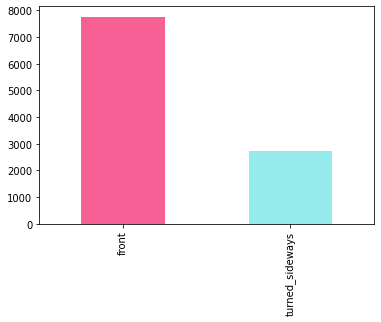

In [18]:
test_df["pose"].value_counts().plot.bar(color = ['#F66095', '#95ebec'])

<AxesSubplot:>

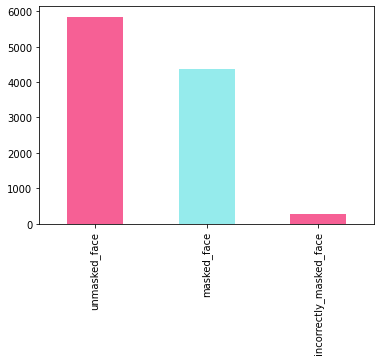

In [19]:
test_df["name"].value_counts().plot.bar(color = ['#F66095', '#95ebec'])

<AxesSubplot:>

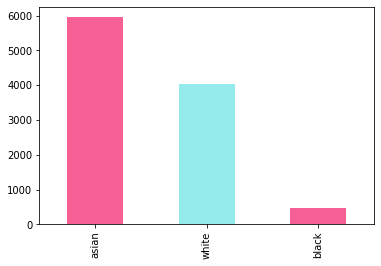

In [20]:
test_df["ethnisity"].value_counts().plot.bar(color = ['#F66095', '#95ebec'])

<AxesSubplot:>

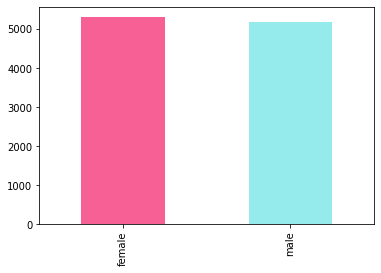

In [21]:
test_df["gender"].value_counts().plot.bar(color = ['#F66095', '#95ebec'])

In [22]:
print(f"Test data-set size: {len(test_df)}")

Test data-set size: 10480


<AxesSubplot:>

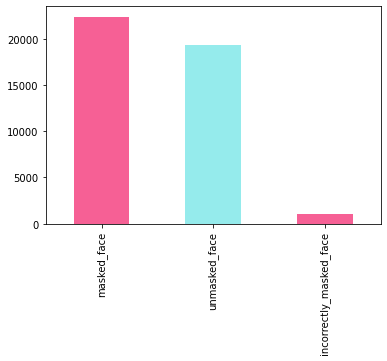

In [23]:
train_df["name"].value_counts().plot.bar(color = ['#F66095', '#95ebec'])

In [24]:
print(f"Train data-set size: {len(train_df)}")

Train data-set size: 42761


In [26]:
# Distribute for testing
dataset_folder = "DS"
dataset_type = "test"
type_folder = f"{dataset_folder}{os.sep}{dataset_type}"

if not os.path.isdir(dataset_folder):
    os.mkdir(dataset_folder)
if not os.path.isdir(type_folder):
    os.mkdir(type_folder)
    
def dist(row):
    cls_folder = "correct" if row["name"] == "masked_face" else "incorrect"
    cls_path = f"{type_folder}{os.sep}{cls_folder}"
    fl_path = row["path"]
    *_, fl_name = fl_path.split(os.sep)
    if not os.path.isdir(cls_path):
        os.mkdir(cls_path)
    copyfile(row["path"], f"{cls_path}{os.sep}{fl_name}")


test_df.apply(dist, axis=1)

0        None
3        None
4        None
5        None
6        None
         ... 
12188    None
12190    None
12191    None
12192    None
12193    None
Length: 10480, dtype: object